# Benchmarks

These benchmark results use the viral genomes from [Meng *et al.*](https://www.biorxiv.org/content/10.1101/2023.02.09.527846v1.abstract):

> Meng, Lingjie, Tom O. Delmont, Morgan Gaia, Eric Pelletier, Antonio Fernandez-Guerra, Samuel Chaffron, Russell Y. Neches et al. "Genomic adaptation of giant viruses in polar oceans." bioRxiv (2023): 2023-02.

with the following NCVOGs :

> Aylward, Frank O., Mohammad Moniruzzaman, Anh D. Ha, and Eugene V. Koonin. "A phylogenomic framework for charting the diversity and evolution of giant viruses." _PLoS biology_ 19, no. 10 (2021): e3001430.|

* NCVOG0022.hmm
* NCVOG0023.hmm
* NCVOG0037.hmm
* NCVOG0038.hmm
* NCVOG0052.hmm
* NCVOG0076.hmm
* NCVOG0236.hmm
* NCVOG0249.hmm
* NCVOG0261.hmm
* NCVOG0262.hmm
* NCVOG0271.hmm
* NCVOG0272.hmm
* NCVOG0273.hmm
* NCVOG0274.hmm
* NCVOG0276.hmm
* NCVOG1060.hmm
* NCVOG1117.hmm
* NCVOG1127.hmm
* NCVOG1164.hmm
* NCVOG1353.hmm

and the following HMMs from Guglielmini *et al.* :

> Guglielmini, Julien, Anthony C. Woo, Mart Krupovic, Patrick Forterre, and Morgan Gaia. "Diversification of giant and large eukaryotic dsDNA viruses predated the origin of modern eukaryotes." Proceedings of the National Academy of Sciences 116, no. 39 (2019): 19585-19592.

* capsid.hmm
* capsid-polinto.hmm
* dnapol.hmm
* pATPase.hmm
* pATPase-polinto.hmm
* primase.hmm
* rnapol1.hmm
* rnapol2.hmm
* tf2s.hmm
* vltf3.hmm

In [258]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
import os
from pathlib import Path
import pandas
import polars
import seaborn
import matplotlib
from numpy import array, linspace, std, mean, median, polyfit, poly1d
from Bio import SeqIO
import scipy.optimize

scalings = {}

In [13]:
basedir = '../benchmarks'

dataframes = []

dtypes = { 'max_rss'   : polars.Float64,
           'max_vms'   : polars.Float64,
           'max_uss'   : polars.Float64,
           'max_pss'   : polars.Float64,
           'io_in'     : polars.Float64,
           'io_out'    : polars.Float64,
           'mean_load' : polars.Float64, 
           'cpu_time'  : polars.Float64, }

per_gene    = [ 'clustalo', 'fasttree', 'trimal', 'filter_alignments' ]
per_cluster = [ 'clusterdata' ]

for ruledir in os.listdir( basedir ) :
    for tsv in os.listdir( os.path.join( basedir, ruledir ) ) :
        f = os.path.join( basedir, ruledir, tsv )
        df = polars.read_csv( f, 
                              separator='\t', 
                              dtypes=dtypes,
                              try_parse_dates=True,
                              null_values=['NA'] ) 
        df = df.with_columns(polars.lit(ruledir).alias('rule'))
        if ruledir in per_gene :
            ani, cid, hmm = Path(tsv).stem.rsplit( '_', 3 )
            df = df.with_columns(polars.lit(float(ani)).alias('ani'))
            df = df.with_columns(polars.lit(int(cid)).alias('cid'))
            df = df.with_columns(polars.lit(hmm).alias('hmm'))
            df = df.with_columns(polars.lit(Path(tsv).stem).alias('run'))
        elif ruledir in per_cluster :
            ani, cid = Path(tsv).stem.rsplit( '_', 2 )
            df = df.with_columns(polars.lit(float(ani)).alias('ani'))
            df = df.with_columns(polars.lit(int(cid)).alias('cid'))
            df = df.with_columns(polars.lit(Path(tsv).stem).alias('run'))
        dataframes.append( df )
benchmarks = polars.concat( dataframes, how='diagonal', rechunk=True ).to_pandas()

In [14]:
benchmarks.head()

,s,h:m:s,max_rss,max_vms,max_uss,max_pss,io_in,io_out,mean_load,cpu_time,rule,ani,cid,hmm,run
0,1.0785,00:00:01,194.92,1221.07,170.50,175.29,0.24,0.38,0.00,0.90,prodigal,NaN,NaN,None,None
1,1.2913,00:00:01,195.16,1221.08,170.59,175.38,0.57,0.64,0.00,0.90,prodigal,NaN,NaN,None,None
2,1.3153,00:00:01,195.16,1221.07,170.71,175.51,0.19,0.16,0.00,0.89,prodigal,NaN,NaN,None,None
3,1.8381,00:00:01,195.70,1221.07,171.25,180.17,0.17,0.20,42.22,1.47,prodigal,NaN,NaN,None,None
4,0.6307,00:00:00,1.68,110.65,0.36,0.37,0.00,0.00,0.00,0.00,prodigal,NaN,NaN,None,None


/user1/scl1/ryneches/opt/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


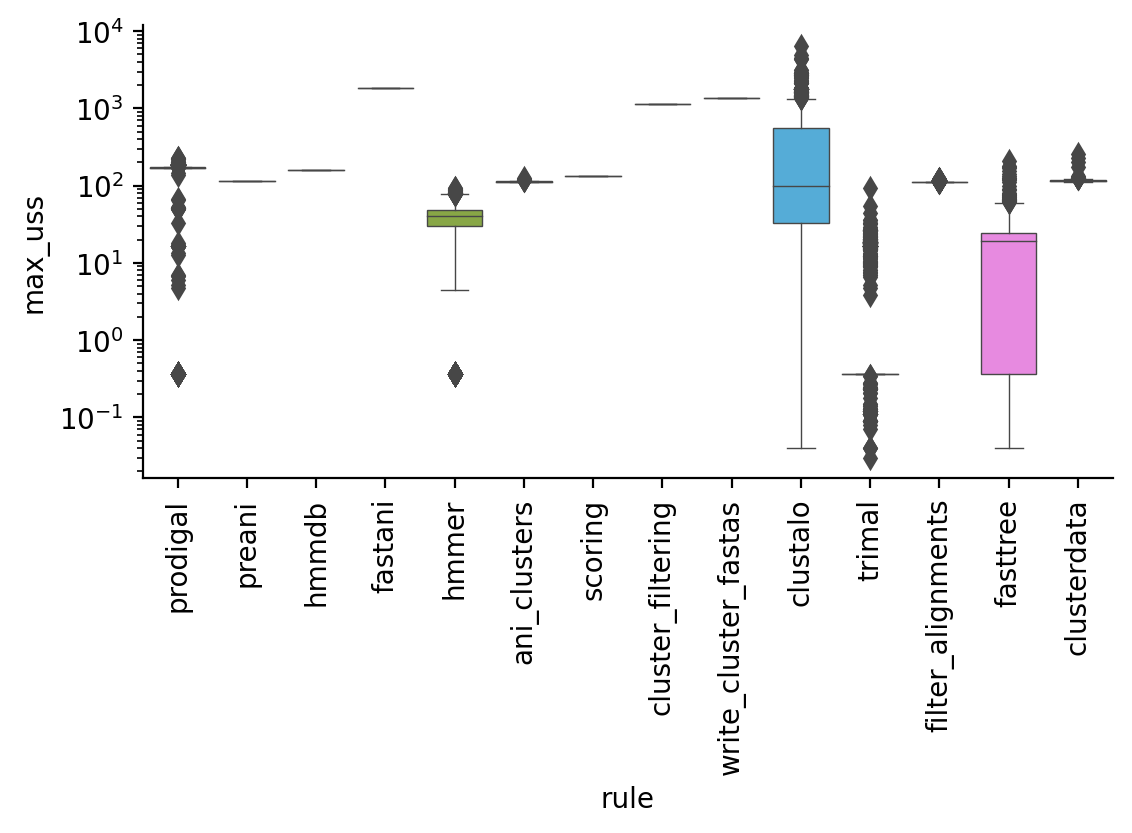

In [175]:
#rules = [ 'prodigal', 'hmmer', 'clustalo', 'fasttree' ]
rules = set( benchmarks['rule'] )

g = seaborn.catplot( data=benchmarks[ benchmarks['rule'].isin(rules) ], 
                     x='rule', 
                     y='max_uss',
                     linewidth=0.5,
                     kind='box',
                     height=3,
                     aspect=2 )
g.ax.set_xticklabels( g.ax.get_xticklabels(), rotation=90 )
g.ax.set_yscale('log')

### Modeling memory usage of `clustalo`

The memory footprint of `clustalo` scales with the length of the largest gene in
the alignment. First, we fit a quadratic function to the data and observe the trend,
and then manually tweak the function to establish a safe envelope.

In [176]:
benchmarks[ benchmarks['rule']=='clustalo' ].describe()

,s,max_rss,max_vms,max_uss,max_pss,io_in,io_out,mean_load,cpu_time,ani,cid
count,4963.000000,4939.000000,4939.000000,4939.000000,4939.000000,4939.000000,4939.000000,4939.000000,4939.000000,4963.000000,4963.000000
mean,18.230633,345.135746,673.418892,336.885256,337.917508,0.004436,0.004635,45.641642,16.058141,80.601048,216.876687
std,126.776800,457.811213,540.275023,456.734297,456.906873,0.103602,0.018698,38.578227,125.067169,4.027817,152.181533
min,0.178400,1.430000,110.540000,0.040000,0.170000,0.000000,0.000000,0.000000,0.000000,75.000000,13.000000
25%,0.786650,42.765000,397.580000,32.655000,33.990000,0.000000,0.000000,0.000000,0.450000,78.000000,96.000000
50%,2.823500,110.550000,483.210000,100.010000,101.370000,0.000000,0.000000,54.390000,2.040000,80.000000,166.000000
75%,9.541250,566.035000,938.840000,556.065000,557.280000,0.000000,0.000000,83.825000,8.650000,83.000000,318.000000
max,3301.417000,6455.810000,7619.190000,6442.980000,6444.420000,3.240000,0.520000,99.290000,3267.080000,94.000000,863.000000


In [189]:
def fastastats( fasta ) :
    n, lengths = 0, []
    for n, rec in enumerate( SeqIO.parse( open( fasta ), 'fasta' ) ) :
        lengths.append( len(rec) )
    if n == 0 :
        return {}
    else :
        return { 'size'       : os.stat( fasta ).st_size,
                 'n'          : n,
                 'min_length' : min(lengths),
                 'max_length' : max(lengths),
                 'med_length' : median(lengths) }

data = []
basedir = '../clusters'
for anidir in os.listdir( basedir ) :
    if os.path.isdir( os.path.join( basedir, anidir ) ) :
        for ciddir in os.listdir( os.path.join( basedir, anidir ) ) :
            for hmmfile in os.listdir( os.path.join( basedir, anidir, ciddir, 'genes' ) ) :
                stats = fastastats( os.path.join( basedir, anidir, ciddir, 'genes', hmmfile ) )
                #stats['hmm'] = Path( hmmfile ).stem
                stats['run'] = '_'.join( [ anidir, ciddir, Path( hmmfile ).stem ] )
                data.append( stats )
filesizes = pandas.DataFrame( data )
filesizes.head()

,size,n,min_length,max_length,med_length,run
0,15399.0,6.0,291.0,2847.0,2634.0,75.0_46_NCVOG0023
1,21435.0,12.0,417.0,1731.0,1689.0,75.0_46_NCVOG0022
2,14679.0,3.0,363.0,5136.0,4068.0,75.0_46_dnapol
3,20752.0,6.0,375.0,4965.0,2784.0,75.0_46_NCVOG1353
4,4444.0,5.0,513.0,591.0,525.0,75.0_46_tf2s


In [44]:
clustalo = filesizes.merge( benchmarks[ benchmarks['rule']=='clustalo' ], on='run' )

[-1.27857624e-06  2.52630610e-01 -2.15201624e+02]


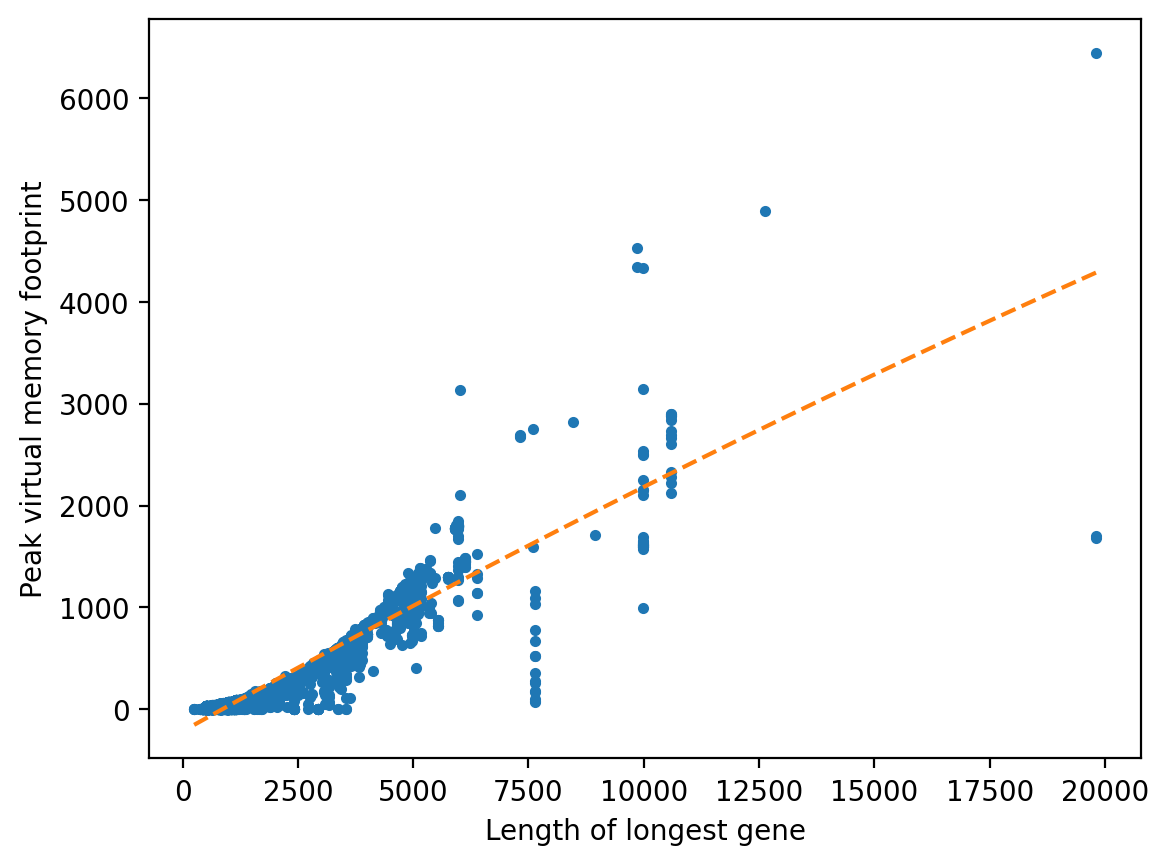

In [268]:
X = array( [ float(x) for x in clustalo.dropna()['max_length'] ] )
Y = array( [ float(x) for x in clustalo.dropna()['max_uss'] ] )
x = linspace( min(X), max(X), 1000 )

scalings['clustalo'] = { 'X' : X, 'Y' : Y, 'x' : x }

trend = polyfit( X, Y, 2 )
trendpoly = poly1d(trend) 

matplotlib.pyplot.plot( X, Y, '.' )
matplotlib.pyplot.plot( x, trendpoly(x), '--' )

matplotlib.pyplot.xlabel( 'Length of longest gene' )
matplotlib.pyplot.ylabel( 'Peak virtual memory footprint' )

print( trend )

Text(0, 0.5, 'Peak virtual memory footprint')

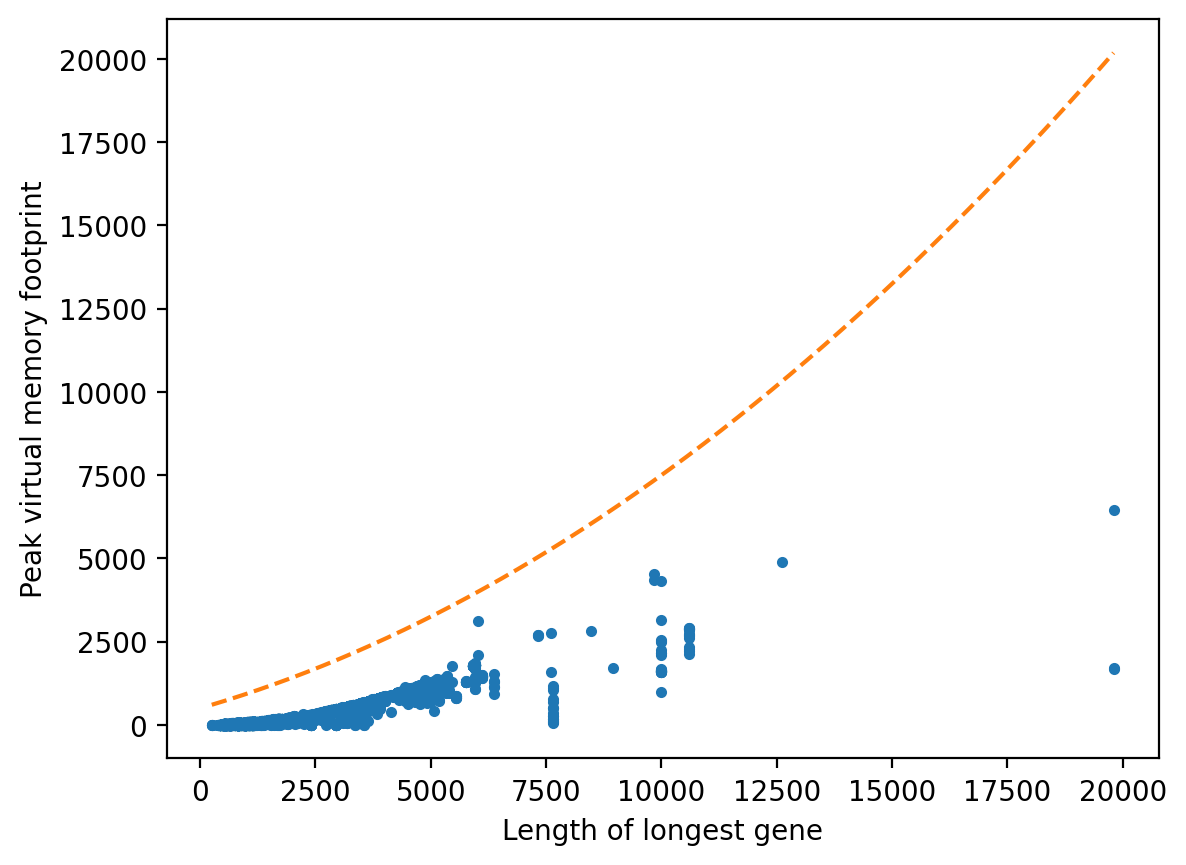

In [269]:
def model( x, a, b, c ) :
    return a * x**2 + b * x + c

a = 3e-5
b = 0.4
c = 500

scalings['clustalo']['a'] = a
scalings['clustalo']['b'] = b
scalings['clustalo']['c'] = c

matplotlib.pyplot.plot( X, Y, '.' )
matplotlib.pyplot.plot( x , model( x, a, b, c ), '--' )

matplotlib.pyplot.xlabel( 'Length of longest gene' )
matplotlib.pyplot.ylabel( 'Peak virtual memory footprint' )

### Modeling memory usage of `trimal`



In [195]:
data = []
basedir = '../clusters'
for anidir in os.listdir( basedir ) :
    if os.path.isdir( os.path.join( basedir, anidir ) ) :
        for ciddir in os.listdir( os.path.join( basedir, anidir ) ) :
            for hmmfile in os.listdir( os.path.join( basedir, anidir, ciddir, 'alignments' ) ) :
                stats = fastastats( os.path.join( basedir, anidir, ciddir, 'alignments', hmmfile ) )
                #stats['hmm'] = Path( hmmfile ).stem
                stats['run'] = '_'.join( [ anidir, ciddir, Path( hmmfile ).stem.rsplit( '_', 1 )[0] ] )
                data.append( stats )
filesizes = pandas.DataFrame( data )
filesizes.head()

,size,n,min_length,max_length,med_length,run
0,29601.0,7.0,3471.0,3471.0,3471.0,75.0_46_NCVOG1117
1,21555.0,6.0,2859.0,2859.0,2859.0,75.0_46_NCVOG0023
2,25916.0,12.0,1792.0,1792.0,1792.0,75.0_46_NCVOG0022
3,22022.0,3.0,5243.0,5243.0,5243.0,75.0_46_dnapol
4,37181.0,6.0,5054.0,5054.0,5054.0,75.0_46_NCVOG1353


In [224]:
trimal = filesizes.merge( benchmarks[ benchmarks['rule']=='trimal' ], on='run' )
trimal.describe()

,size,n,min_length,max_length,med_length,s,max_rss,max_vms,max_uss,max_pss,io_in,io_out,mean_load,cpu_time,ani,cid
count,4.777000e+03,4777.000000,4777.000000,4777.000000,4777.000000,4963.000000,4551.000000,4551.000000,4551.000000,4551.000000,4551.000000,4551.000000,4551.000000,4551.000000,4963.000000,4963.000000
mean,2.212273e+04,16.558091,1700.424744,1700.424744,1700.424744,0.426779,3.262351,124.996851,1.503757,1.581116,0.038917,0.002296,1.216486,0.126449,80.601048,216.876687
std,4.595632e+04,47.320666,1316.383394,1316.383394,1316.383394,2.243853,6.388123,57.546291,4.717753,4.983115,0.507216,0.053566,9.351437,1.916193,4.027817,152.181533
min,3.610000e+02,2.000000,4.000000,4.000000,4.000000,0.178900,1.180000,110.540000,0.030000,0.150000,0.000000,0.000000,0.000000,0.000000,75.000000,13.000000
25%,5.687000e+03,4.000000,744.000000,744.000000,744.000000,0.217700,1.670000,110.650000,0.360000,0.360000,0.000000,0.000000,0.000000,0.000000,78.000000,96.000000
50%,1.174600e+04,6.000000,1089.000000,1089.000000,1089.000000,0.227900,1.670000,110.650000,0.360000,0.360000,0.000000,0.000000,0.000000,0.000000,80.000000,166.000000
75%,2.325700e+04,11.000000,2727.000000,2727.000000,2727.000000,0.253200,1.680000,110.650000,0.360000,0.370000,0.000000,0.000000,0.000000,0.000000,83.000000,318.000000
max,1.082438e+06,796.000000,8137.000000,8137.000000,8137.000000,115.412200,103.400000,607.180000,93.960000,94.990000,15.400000,2.980000,94.940000,105.710000,94.000000,863.000000


[-1.93380688e-05  7.21490297e-02  3.36316449e-01]


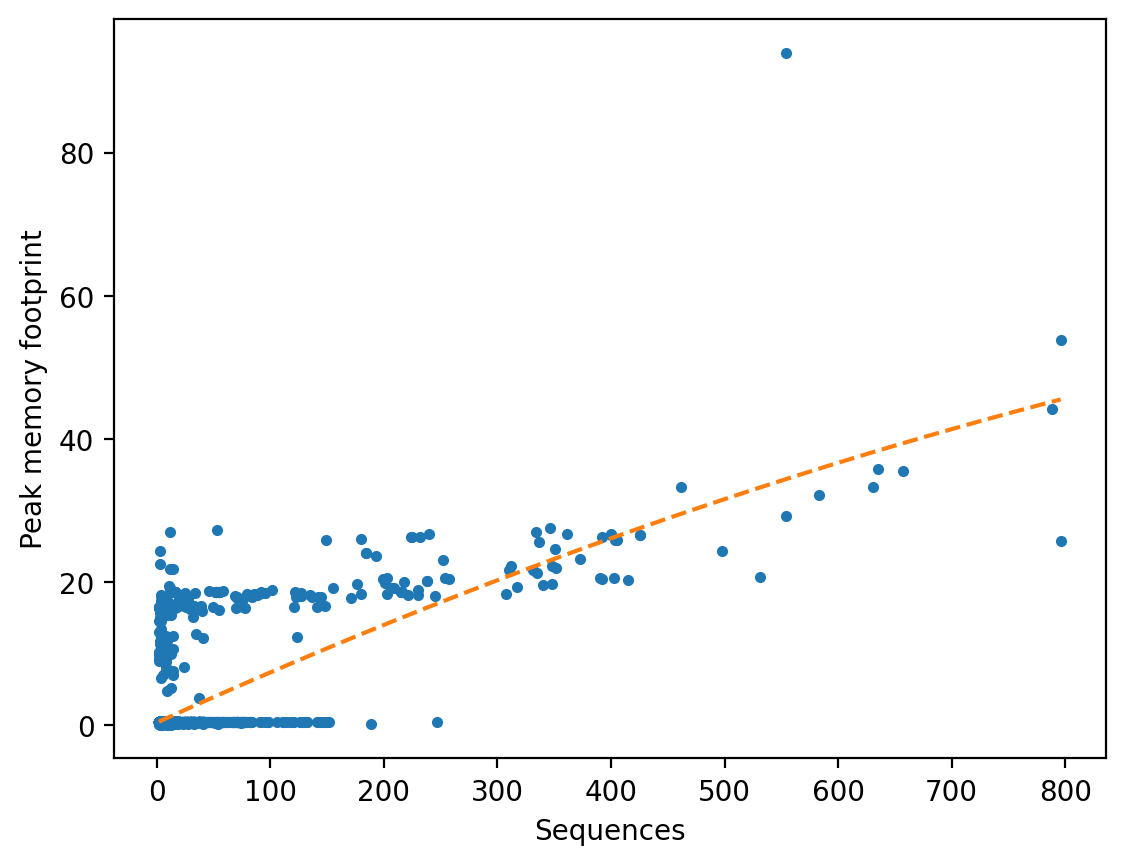

In [287]:
X = array( [ float(row['n']) for n,row in trimal.dropna().iterrows() ] )
Y = array( [ float(x) for x in trimal.dropna()['max_uss'] ] )
x = linspace( min(X), max(X), 1000 )

scalings['trimal'] = { 'X' : X, 'Y' : Y, 'x' : x }

trend = polyfit( X, Y, 2 )
trendpoly = poly1d(trend) 

matplotlib.pyplot.plot( X, Y, '.' )
matplotlib.pyplot.plot( x, trendpoly(x), '--' )

matplotlib.pyplot.xlabel( 'Sequences' )
matplotlib.pyplot.ylabel( 'Peak memory footprint' )

print( trend )

Text(0, 0.5, 'Peak memory footprint')

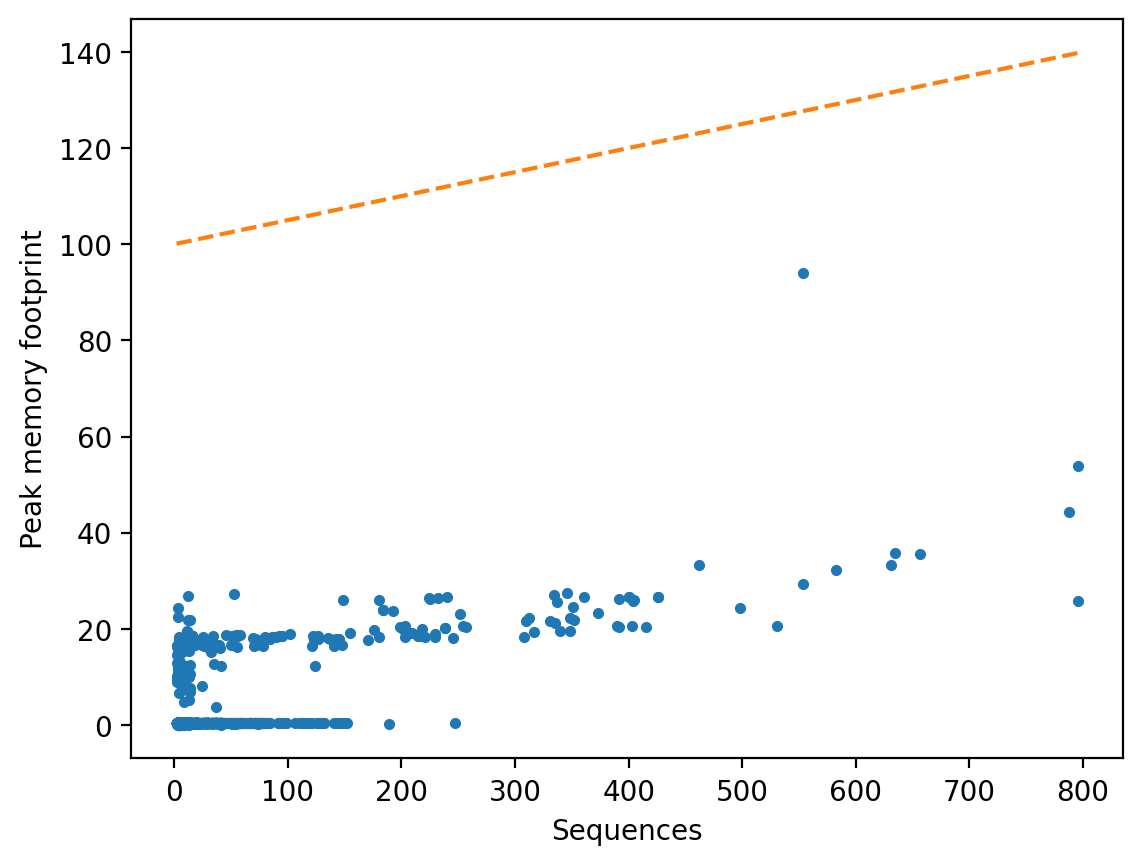

In [288]:
def model( x, a, b, c ) :
    return a * x**2 + b * x + c

a = 0
b = 0.05
c = 100

scalings['trimal']['a'] = a
scalings['trimal']['b'] = b
scalings['trimal']['c'] = c

matplotlib.pyplot.plot( X, Y, '.' )
matplotlib.pyplot.plot( x , model( x, a, b, c ), '--' )

matplotlib.pyplot.xlabel( 'Sequences' )
matplotlib.pyplot.ylabel( 'Peak memory footprint' )

### Modeling memory usage of `fasttree`

In [211]:
data = []
basedir = '../clusters'
for anidir in os.listdir( basedir ) :
    if os.path.isdir( os.path.join( basedir, anidir ) ) :
        for ciddir in os.listdir( os.path.join( basedir, anidir ) ) :
            for hmmfile in os.listdir( os.path.join( basedir, anidir, ciddir, 'filtered_trimmed_alignments' ) ) :
                stats = fastastats( os.path.join( basedir, anidir, ciddir, 'filtered_trimmed_alignments', hmmfile ) )
                #stats['hmm'] = Path( hmmfile ).stem
                stats['run'] = '_'.join( [ anidir, ciddir, Path( hmmfile ).stem.rsplit( '_', 1 )[0] ] )
                data.append( stats )
filesizes = pandas.DataFrame( data )
filesizes.head()

,size,n,min_length,max_length,med_length,run
0,10758.0,3.0,2600.0,2600.0,2600.0,75.0_46_NCVOG0023
1,16486.0,9.0,1577.0,1577.0,1577.0,75.0_46_NCVOG0022
2,10071.0,2.0,3256.0,3256.0,3256.0,75.0_46_dnapol
3,17177.0,5.0,2772.0,2772.0,2772.0,75.0_46_NCVOG1353
4,3304.0,5.0,498.0,498.0,498.0,75.0_46_tf2s


In [212]:
fasttree = filesizes.merge( benchmarks[ benchmarks['rule']=='fasttree' ], on='run' )
fasttree.describe()

,size,n,min_length,max_length,med_length,s,max_rss,max_vms,max_uss,max_pss,io_in,io_out,mean_load,cpu_time,ani,cid
count,4.777000e+03,4777.000000,4777.000000,4777.000000,4777.000000,4963.000000,4892.000000,4892.000000,4892.000000,4892.000000,4892.000000,4892.000000,4892.000000,4892.000000,4963.000000,4963.000000
mean,2.212273e+04,16.558091,1700.424744,1700.424744,1700.424744,1.813640,22.551065,273.617537,16.708132,17.303645,0.000155,0.021521,20.118044,1.296410,80.601048,216.876687
std,4.595632e+04,47.320666,1316.383394,1316.383394,1316.383394,4.426828,19.376403,131.967497,16.331974,16.710052,0.004524,0.075257,30.461868,3.652141,4.027817,152.181533
min,3.610000e+02,2.000000,4.000000,4.000000,4.000000,0.175400,1.180000,110.540000,0.040000,0.140000,0.000000,0.000000,0.000000,0.000000,75.000000,13.000000
25%,5.687000e+03,4.000000,744.000000,744.000000,744.000000,0.417050,1.670000,110.650000,0.360000,0.360000,0.000000,0.000000,0.000000,0.000000,78.000000,96.000000
50%,1.174600e+04,6.000000,1089.000000,1089.000000,1089.000000,0.780500,28.340000,374.500000,19.480000,20.450000,0.000000,0.010000,0.000000,0.460000,80.000000,166.000000
75%,2.325700e+04,11.000000,2727.000000,2727.000000,2727.000000,1.651950,33.162500,379.412500,24.365000,25.312500,0.000000,0.020000,43.405000,1.060000,83.000000,318.000000
max,1.082438e+06,796.000000,8137.000000,8137.000000,8137.000000,105.055800,214.710000,560.560000,205.710000,206.600000,0.140000,1.600000,96.980000,77.120000,94.000000,863.000000


[-3.21268130e-10  4.44389322e-04  9.40992061e+00]


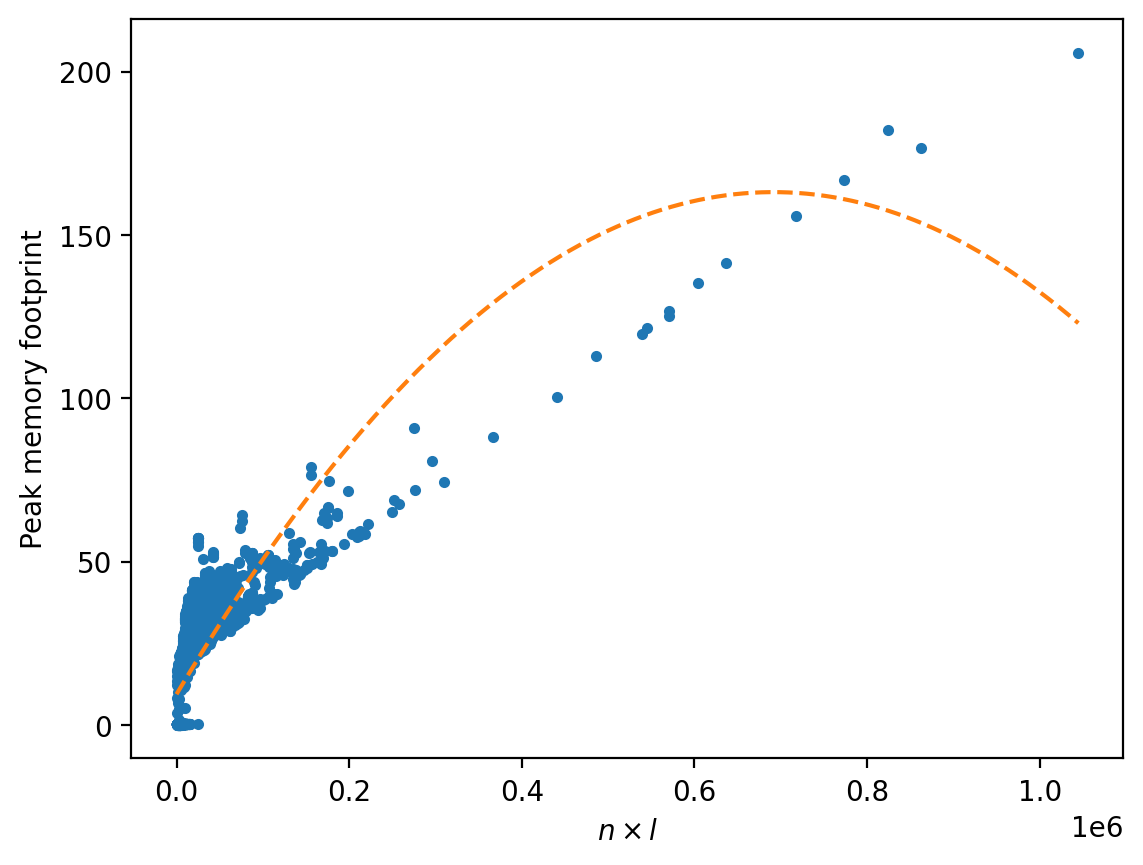

In [272]:
X = array( [ float(row['n']*row['med_length']) for n,row in fasttree.dropna().iterrows() ] )
Y = array( [ float(x) for x in fasttree.dropna()['max_uss'] ] )
x = linspace( min(X), max(X), 1000 )

scalings['fasttree'] = { 'X' : X, 'Y' : Y, 'x' : x }

trend = polyfit( X, Y, 2 )
trendpoly = poly1d(trend) 

matplotlib.pyplot.plot( X, Y, '.' )
matplotlib.pyplot.plot( x, trendpoly(x), '--' )

matplotlib.pyplot.xlabel( r'$n \times l$' )
matplotlib.pyplot.ylabel( 'Peak memory footprint' )

print( trend )

Text(0, 0.5, 'Peak memory footprint')

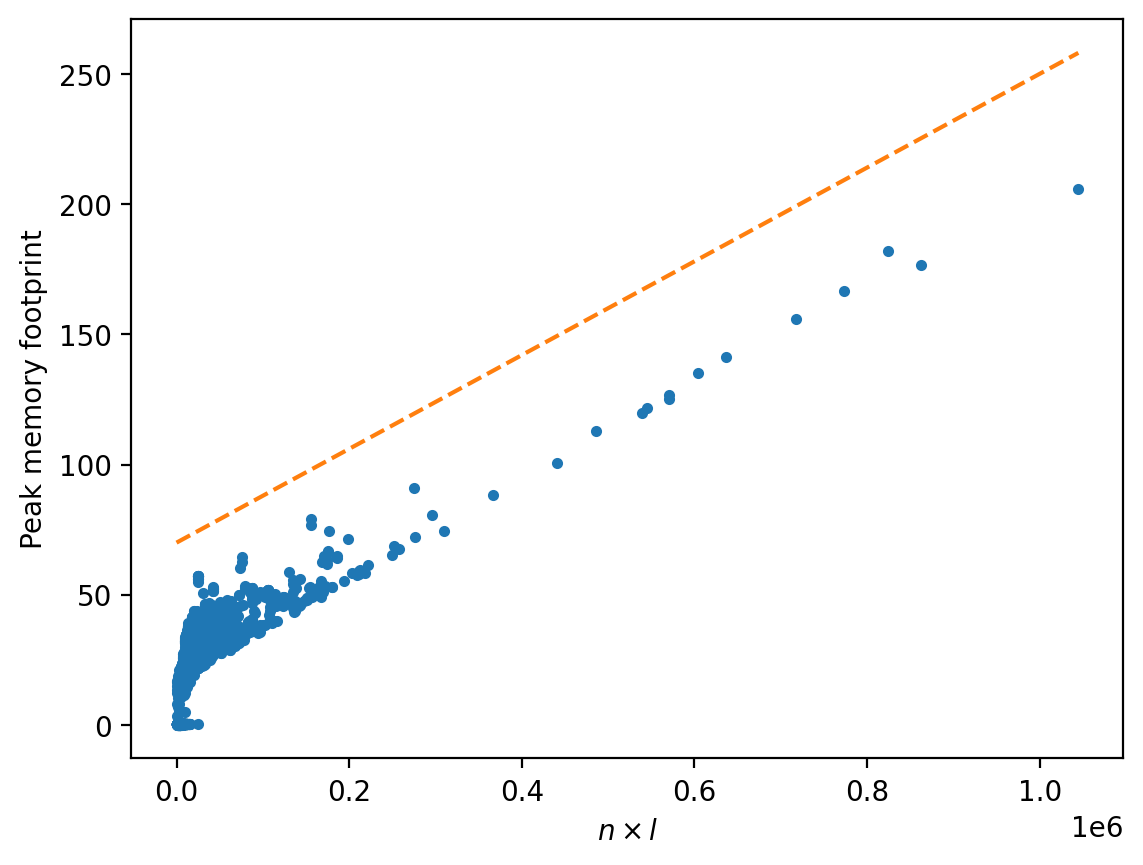

In [273]:
def model( x, a, b, c ) :
    return a * x**2 + b * x + c

a = 0
b = 1.8e-4
c = 70

scalings['fasttree']['a'] = a
scalings['fasttree']['b'] = b
scalings['fasttree']['c'] = c

matplotlib.pyplot.plot( X, Y, '.' )
matplotlib.pyplot.plot( x , model( x, a, b, c ), '--' )

matplotlib.pyplot.xlabel( r'$n \times l$' )
matplotlib.pyplot.ylabel( 'Peak memory footprint' )

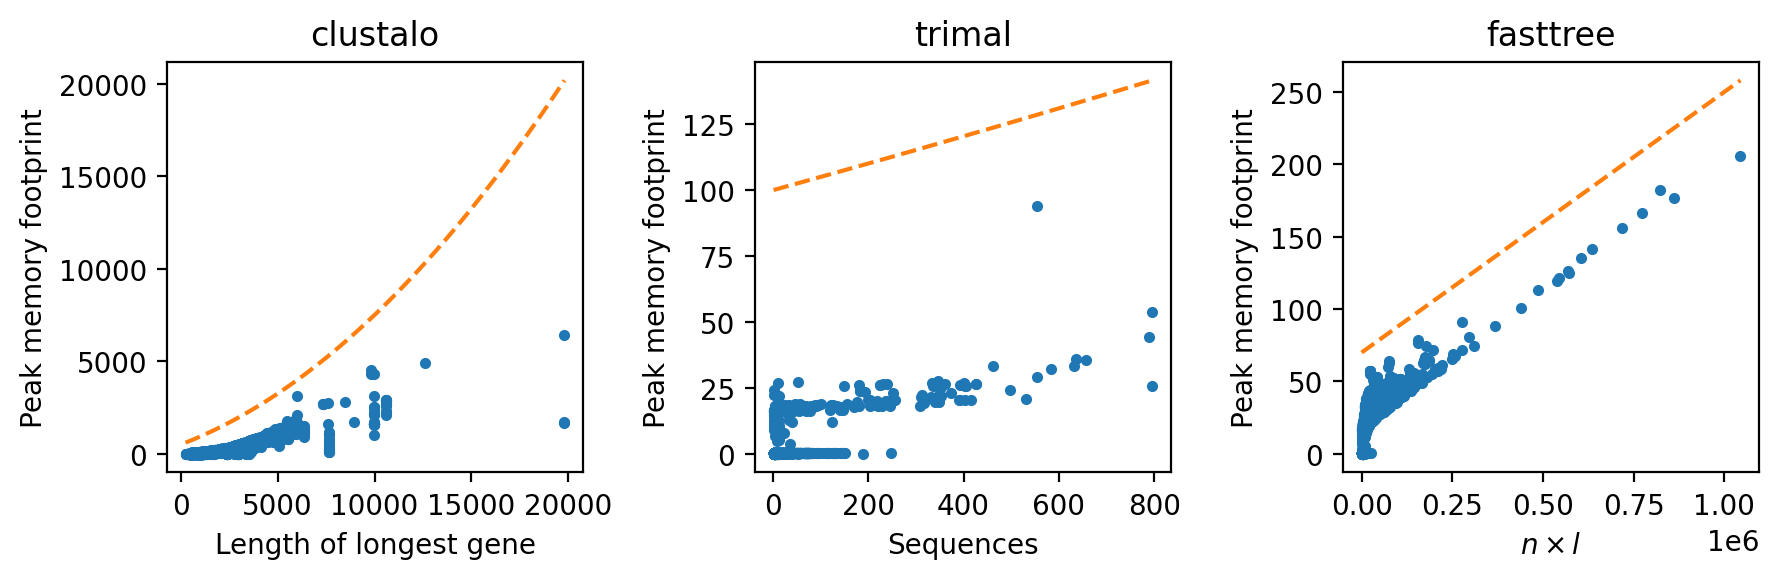

In [285]:
matplotlib.pyplot.figure( figsize=( 9, 3 ) )

tools = [ 'clustalo', 'trimal', 'fasttree' ]
laws  = [ 'Length of longest gene', 'Sequences', r'$n \times l$' ]

for n,(tool,law) in enumerate( zip( tools, laws ) ) :
    
    matplotlib.pyplot.subplot( 1, 3, n+1 )
    
    matplotlib.pyplot.plot( scalings[tool]['X'], scalings[tool]['Y'], '.' )
    matplotlib.pyplot.plot( scalings[tool]['x'],
                            model( scalings[tool]['x'], 
                                   scalings[tool]['a'],
                                   scalings[tool]['b'],
                                   scalings[tool]['c'] ), '--' )
    
    matplotlib.pyplot.title( tool )
    matplotlib.pyplot.xlabel( law )
    matplotlib.pyplot.ylabel( 'Peak memory footprint' )

matplotlib.pyplot.tight_layout()